In [2]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
import nibabel as nib
from scipy.stats import zscore
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pickle

subjects =  ['sub-EZ9NM','sub-TV7EF','sub-WLC4O','sub-3L109','sub-3UYSS','sub-JVPPA','sub-EDOP8',
             'sub-TIJD1','sub-AYDLR','sub-98UT7','sub-4G9A5','sub-YJBI8','sub-FG8PD','sub-BBN4K',
             'sub-F61IR','sub-M1ZRL','sub-NZJZN','sub-XZ9SS','sub-L05R3','sub-ZOVPY','sub-6PEOF',
             'sub-G6RPG','sub-TPNCU','sub-9ADGJ','sub-27IXQ','sub-NDX5S','sub-OE7EZ','sub-28E84',
             'sub-ENN9N','sub-28OBV','sub-8WJAP','sub-SPHBN','sub-WP8SX','sub-BG4CW','sub-AVQEZ',
             'sub-YLWD1','sub-0A4MV','sub-8PIML','sub-4T7NM','sub-X5RE0','sub-RUQON','sub-JVT46',
             'sub-RTFX9','sub-OWWAF','sub-IC2KG','sub-S3I4J','sub-XFQA1','sub-UKF5L','sub-Z0MJJ',
             'sub-9HMVR','sub-DBQ8H','sub-NAD3W','sub-KH33B','sub-JASQ6','sub-T6FHZ','sub-PQ8JD',
             'sub-NOVID','sub-XAKBX','sub-JVSIQ','sub-D1FKN','sub-R3JA3','sub-GPMCX','sub-H8QL5',
             'sub-6HW3V','sub-WF939']

# Load subcortical atlas
BN_atlas = nib.load("utils/brain_atlas/BN_fmriprep.nii").get_fdata()
hippocampus_idx = [215, 216, 217, 218]
hippocampus_label = ['rostral-left','rostral-right','caudal-left','caudal-right']

# Load cortical atlas (Schaefer2018)
Schaefer_atlas_parcel = [100,200,300,400,500,600,700,800,900,1000]
Schaefer_atlas = []
for num_rois in Schaefer_atlas_parcel:
    Schaefer_atlas.append(nib.load(f"utils/brain_atlas/Schaefer2018_cortical_{num_rois}_3mm.nii.gz").get_fdata())

save = False
if save:
    hippocampal_timeseries = np.zeros((len(subjects), 610))
    cortical_timeseries = np.zeros((len(subjects), len(Schaefer_atlas_parcel)), dtype='object')
    for s, fname in enumerate(subjects):
        print(fname)
        path = f'/DATA2/FilmMemory_preprocess/mrbean_scrambled/{fname}_scrambled_smoothing_scale.nii.gz'
        fmri_data = nib.load(path).get_fdata()

        tmp = []
        for roi in hippocampus_idx:
            roi_timeseries = zscore(fmri_data[BN_atlas==roi, :].T, axis=0)
            roi_timeseries = np.nan_to_num(roi_timeseries).mean(axis=1) #610, #voxels
            tmp.append(roi_timeseries)
        hippocampal_timeseries[s,:] = np.mean(tmp, axis=0).astype(np.double)

        for j, num_rois in enumerate(Schaefer_atlas_parcel):
            tmp_timeseries = np.zeros((610, num_rois))
            for r in range(num_rois):
                roi_timeseries = zscore(fmri_data[Schaefer_atlas[j]==r+1,:].T, axis=0)
                roi_timeseries = np.nan_to_num(roi_timeseries).mean(axis=1) #610, #voxels
                tmp_timeseries[:,r] = np.array(roi_timeseries).astype(np.double)
            cortical_timeseries[s,j] = tmp_timeseries
    np.save(f'_DATA/hippocampal_timeseries.npy', hippocampal_timeseries)
    np.save(f'_DATA/cortical_timeseries.npy', cortical_timeseries)
else:
    hippocampal_timeseries = np.load(f'_DATA/hippocampal_timeseries.npy')
    cortical_timeseries = np.load(f'_DATA/cortical_timeseries.npy', allow_pickle=True)

print(hippocampal_timeseries.shape, cortical_timeseries.shape)

content_score = np.load("_DATA/content_score.npy")
ordering_score = np.load("_DATA/ordering_score.npy")

(65, 610) (65, 10)


In [3]:
import pickle
with open('utils/movie/backward_sequencing_related.pkl', 'rb') as f:
    backward_sequencing_related = pickle.load(f)
with open('utils/movie/forward_sequencing_related.pkl', 'rb') as f:
    forward_sequencing_related = pickle.load(f)

all_timepoints = np.ones(610)
sequencing_moments = np.zeros(610)
for pair in backward_sequencing_related:
    sequencing_moments[pair[1]+3:pair[1]+7] = 1  # +3 to +8 due to 1s offset

for pair in forward_sequencing_related:
    sequencing_moments[pair[1]-8:pair[1]-4] = 1 # -8 to -3

event_boundaries = np.array([34,  69,  103, 140, 176, 209, 243, 276, 313, 346, 382, 421, 458, 491, 527, 566, 599])
post_boundaries = np.zeros(610)
for s, scene in enumerate(event_boundaries):
    post_boundaries[scene+4:scene+8] = 1
times = [all_timepoints, post_boundaries, sequencing_moments]


In [4]:
save = False
if save:
    hippocampo_cortical_FC = []
    for nr, num_rois in enumerate(Schaefer_atlas_parcel):
        print(num_rois)
        tmp_hippocampo_cortical_FC = np.zeros((len(subjects), num_rois, len(times)))
        for i, fname in enumerate(subjects):
            for t, time in enumerate(times):
                for r in range(num_rois):
                    tmp_hippocampo_cortical_FC[i,r,t] = pearsonr(hippocampal_timeseries[i,time==1],
                                                                 cortical_timeseries[i,nr][time==1, r])[0]
        hippocampo_cortical_FC.append(tmp_hippocampo_cortical_FC)
    print('done!')

    with open('_DATA/hippocampo_cortical_FC.pkl', 'wb') as f:
        pickle.dump(hippocampo_cortical_FC, f)
else:
    with open('_DATA/hippocampo_cortical_FC.pkl', 'rb') as f:
        hippocampo_cortical_FC = pickle.load(f)

In [6]:
from multiprocessing import Pool
selection_threshold = 0.05
def get_LOO_prediction(test_idx):
    test_sub = np.eye(65)[test_idx]==1
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    positive_edges = np.array(positive_edges)
    negative_edges = np.array(negative_edges)
    if len(positive_edges)>0:
        positive_train = np.sum(FC[train_subs,:][:,positive_edges], axis=1)
        positive_test = np.sum(FC[test_sub,:][:,positive_edges], axis=1)
    else:
        positive_train = np.zeros(64)
        positive_test = np.zeros(1)
    if len(negative_edges)>0:
        negative_train = np.sum(FC[train_subs,:][:,negative_edges], axis=1)
        negative_test = np.sum(FC[test_sub,:][:,negative_edges], axis=1)
    else:
        negative_train = np.zeros(64)
        negative_test = np.zeros(1)
    X_train = np.vstack([positive_train, negative_train]).T
    X_test = np.vstack([positive_test, negative_test]).T
    y_train = behavioral_score[train_subs]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)[0]
    return y_pred

save = False
if save:
    model_predictivity = np.zeros((len(Schaefer_atlas_parcel), 2, len(times)))
    for nr, num_rois in enumerate(Schaefer_atlas_parcel):
        num_edges = num_rois
        for b, behavioral_score in enumerate([ordering_score, content_score]):
            if b == 0:
                name='ordering'
            else:
                name='content'
            predictivity_r = []
            for t, time in enumerate(times):
                FC = hippocampo_cortical_FC[nr][:,:,t]
                FC = np.arctanh(FC)
                with Pool() as pool:
                    behavioral_prediction = pool.map(get_LOO_prediction, [i for i in np.arange(len(subjects))])
                r, p = pearsonr(behavioral_prediction, behavioral_score)
                predictivity_r.append(r)
                model_predictivity[nr, b, t] = r
            print(num_rois, name, predictivity_r)
    np.save('_DATA/hippocampo_cortical_model_predictivity.npy', model_predictivity)
else:
    model_predictivity = np.load('_DATA/hippocampo_cortical_model_predictivity.npy')

In [5]:
# Null distribution

from multiprocessing import Pool
selection_threshold = 0.05
def get_LOO_nulldistribution(test_idx):
    test_sub = np.eye(65)[test_idx]==1
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score_suffle[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    positive_edges = np.array(positive_edges)
    negative_edges = np.array(negative_edges)
    if len(positive_edges)>0:
        positive_train = np.sum(FC[train_subs,:][:,positive_edges], axis=1)
        positive_test = np.sum(FC[test_sub,:][:,positive_edges], axis=1)
    else:
        positive_train = np.zeros(64)
        positive_test = np.zeros(1)
    if len(negative_edges)>0:
        negative_train = np.sum(FC[train_subs,:][:,negative_edges], axis=1)
        negative_test = np.sum(FC[test_sub,:][:,negative_edges], axis=1)
    else:
        negative_train = np.zeros(64)
        negative_test = np.zeros(1)
    X_train = np.vstack([positive_train, negative_train]).T
    X_test = np.vstack([positive_test, negative_test]).T
    y_train = behavioral_score_suffle[train_subs]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)[0]
    return y_pred

atlas_idx = 1
num_rois = Schaefer_atlas_parcel[atlas_idx]
print("#ROIs:", num_rois)
num_edges = num_rois

times = [all_timepoints, 
         post_boundaries,
         sequencing_moments]

with open('_DATA/hippocampo_cortical_FC.pkl', 'rb') as f:
    hippocampo_cortical_FC = pickle.load(f)

N_permutations = 1000
model_random_permutation = np.zeros((2,len(times),N_permutations))
for b, behavioral_score in enumerate([ordering_score, content_score]):
    if b == 0:
        name='ordering'
    else:
        name='content'
    for t, time in enumerate(times):
        FC = hippocampo_cortical_FC[atlas_idx][:,:,t]
        FC = np.arctanh(FC)
        np.random.seed(0)  # For reproducibility
        for p in range(N_permutations):
            if p % 100 == 0:
                print("Score type:", name, "Time idx:", t, f'{100*p/N_permutations:3.3f}%')
            behavioral_score_suffle = np.copy(behavioral_score[np.random.permutation(len(subjects))])
            with Pool() as pool:
                behavioral_prediction = pool.map(get_LOO_nulldistribution, [i for i in np.arange(len(subjects))])
            r, _ = pearsonr(behavioral_score_suffle, behavioral_prediction)
            model_random_permutation[b,t,p] = r
np.save('data/hippocampo_cortical_null_predictivity.npy', model_random_permutation)

#ROIs: 200
Score type: ordering Time idx: 0 0.000%
Score type: ordering Time idx: 0 10.000%
Score type: ordering Time idx: 0 20.000%
Score type: ordering Time idx: 0 30.000%
Score type: ordering Time idx: 0 40.000%
Score type: ordering Time idx: 0 50.000%
Score type: ordering Time idx: 0 60.000%
Score type: ordering Time idx: 0 70.000%
Score type: ordering Time idx: 0 80.000%
Score type: ordering Time idx: 0 90.000%
Score type: ordering Time idx: 1 0.000%
Score type: ordering Time idx: 1 10.000%
Score type: ordering Time idx: 1 20.000%
Score type: ordering Time idx: 1 30.000%
Score type: ordering Time idx: 1 40.000%
Score type: ordering Time idx: 1 50.000%
Score type: ordering Time idx: 1 60.000%
Score type: ordering Time idx: 1 70.000%
Score type: ordering Time idx: 1 80.000%
Score type: ordering Time idx: 1 90.000%
Score type: ordering Time idx: 2 0.000%
Score type: ordering Time idx: 2 10.000%
Score type: ordering Time idx: 2 20.000%
Score type: ordering Time idx: 2 30.000%
Score ty

## Whole-brain cortical FC without Hippocampus

In [7]:
times = [all_timepoints, post_boundaries, sequencing_moments]
num_rois = 200
save = False
if save:
    wholebrain_FC = np.zeros((len(subjects), int(num_rois*(num_rois-1)/2), len(times)))
    for i, fname in enumerate(subjects):
        for t, time in enumerate(times):
            counter = 0
            for r_1 in range(num_rois):
                for r_2 in range(num_rois):
                    if r_1 > r_2:
                        wholebrain_FC[i,counter,t] = pearsonr(cortical_timeseries[i,1][time==1, r_1],
                                                              cortical_timeseries[i,1][time==1, r_2])[0]
                        counter+=1
    print('done!')

    np.save('_DATA/cortico_cortical_FC_without_hippocampus.npy', wholebrain_FC)
else:
    wholebrain_FC = np.load('_DATA/cortico_cortical_FC_without_hippocampus.npy')

In [7]:
from multiprocessing import Pool
selection_threshold = 0.05
def get_LOO_prediction(test_idx):
    test_sub = np.eye(65)[test_idx]==1
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    positive_edges = np.array(positive_edges)
    negative_edges = np.array(negative_edges)
    if len(positive_edges)>0:
        positive_train = np.sum(FC[train_subs,:][:,positive_edges], axis=1)
        positive_test = np.sum(FC[test_sub,:][:,positive_edges], axis=1)
    else:
        positive_train = np.zeros(64)
        positive_test = np.zeros(1)
    if len(negative_edges)>0:
        negative_train = np.sum(FC[train_subs,:][:,negative_edges], axis=1)
        negative_test = np.sum(FC[test_sub,:][:,negative_edges], axis=1)
    else:
        negative_train = np.zeros(64)
        negative_test = np.zeros(1)
    X_train = np.vstack([positive_train, negative_train]).T
    X_test = np.vstack([positive_test, negative_test]).T
    y_train = behavioral_score[train_subs]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)[0]
    return y_pred

num_rois = 200
num_edges = int(num_rois*(num_rois-1)/2)
save = False
if save:
    model_predictivity = np.zeros((2, len(times)))
    for b, behavioral_score in enumerate([ordering_score, content_score]):
        if b == 0:
            name='ordering'
        else:
            name='content'
        predictivity_r = []
        for t, time in enumerate(times):
            FC = wholebrain_FC[:,:,t]
            FC = np.arctanh(FC)
            with Pool() as pool:
                behavioral_prediction = pool.map(get_LOO_prediction, [i for i in np.arange(len(subjects))])
            r, p = pearsonr(behavioral_prediction, behavioral_score)
            predictivity_r.append(r)
            model_predictivity[b, t] = r
        print(num_rois, name, predictivity_r)
    np.save('_DATA/cortico_cortical_without_hippocampus_model_predictivity.npy', model_predictivity)
else:
    model_predictivity = np.load('_DATA/cortico_cortical_without_hippocampus_model_predictivity.npy')

200 ordering [-0.032663088984404, -0.29030976882939963, -0.171276608474482]
200 content [0.1812195269507542, 0.025623396558638697, 0.10134110363113123]


In [8]:
# Null distribution

from multiprocessing import Pool
selection_threshold = 0.05
def get_LOO_nulldistribution(test_idx):
    test_sub = np.eye(65)[test_idx]==1
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score_suffle[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    positive_edges = np.array(positive_edges)
    negative_edges = np.array(negative_edges)
    if len(positive_edges)>0:
        positive_train = np.sum(FC[train_subs,:][:,positive_edges], axis=1)
        positive_test = np.sum(FC[test_sub,:][:,positive_edges], axis=1)
    else:
        positive_train = np.zeros(64)
        positive_test = np.zeros(1)
    if len(negative_edges)>0:
        negative_train = np.sum(FC[train_subs,:][:,negative_edges], axis=1)
        negative_test = np.sum(FC[test_sub,:][:,negative_edges], axis=1)
    else:
        negative_train = np.zeros(64)
        negative_test = np.zeros(1)
    X_train = np.vstack([positive_train, negative_train]).T
    X_test = np.vstack([positive_test, negative_test]).T
    y_train = behavioral_score_suffle[train_subs]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)[0]
    return y_pred

num_rois = 200
num_edges = int(num_rois*(num_rois-1)/2)
N_permutations = 1000
save = True
if save:
    model_random_permutation = np.zeros((2,len(times),N_permutations))
    for b, behavioral_score in enumerate([ordering_score, content_score]):
        if b == 0:
            name='ordering'
        else:
            name='content'
        for t, time in enumerate(times):
            FC  = wholebrain_FC[:,:,t]
            FC = np.arctanh(FC)
            np.random.seed(0)
            for p in range(N_permutations):
                if p % 100 == 0:
                    print("Score type:", name, "Time idx:", t, f'{100*p/N_permutations:3.3f}%')
                behavioral_score_suffle = np.copy(behavioral_score[np.random.permutation(len(subjects))])
                with Pool() as pool:
                    behavioral_prediction = pool.map(get_LOO_nulldistribution, [i for i in np.arange(len(subjects))])
                r, _ = pearsonr(behavioral_score_suffle, behavioral_prediction)
                model_random_permutation[b,t,p] = r

    np.save("data/cortico_cortical_without_hippocampus_null_predictivity.npy", model_random_permutation)

Score type: ordering Time idx: 0 0.000%
Score type: ordering Time idx: 0 10.000%
Score type: ordering Time idx: 0 20.000%
Score type: ordering Time idx: 0 30.000%
Score type: ordering Time idx: 0 40.000%
Score type: ordering Time idx: 0 50.000%
Score type: ordering Time idx: 0 60.000%
Score type: ordering Time idx: 0 70.000%
Score type: ordering Time idx: 0 80.000%
Score type: ordering Time idx: 0 90.000%
Score type: ordering Time idx: 1 0.000%
Score type: ordering Time idx: 1 10.000%
Score type: ordering Time idx: 1 20.000%
Score type: ordering Time idx: 1 30.000%
Score type: ordering Time idx: 1 40.000%
Score type: ordering Time idx: 1 50.000%
Score type: ordering Time idx: 1 60.000%
Score type: ordering Time idx: 1 70.000%
Score type: ordering Time idx: 1 80.000%
Score type: ordering Time idx: 1 90.000%
Score type: ordering Time idx: 2 0.000%
Score type: ordering Time idx: 2 10.000%
Score type: ordering Time idx: 2 20.000%
Score type: ordering Time idx: 2 30.000%
Score type: orderin

0 2 0.3147941556116186 0.022977022977022976
0 1 -0.10423052176410277 0.6413586413586414
0 0 0.045163120631117507 0.3876123876123876
1 2 0.054449651402335514 0.31868131868131866
1 1 0.2998089418135322 0.03396603396603397
1 0 0.247773209734041 0.06693306693306693


/tmp/ipykernel_1681868/2943392378.py:57: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#777777'` for the same effect.

  sns.violinplot(data=dfs[b], x='moments', y='null',
/tmp/ipykernel_1681868/2943392378.py:57: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#777777'` for the same effect.

  sns.violinplot(data=dfs[b], x='moments', y='null',


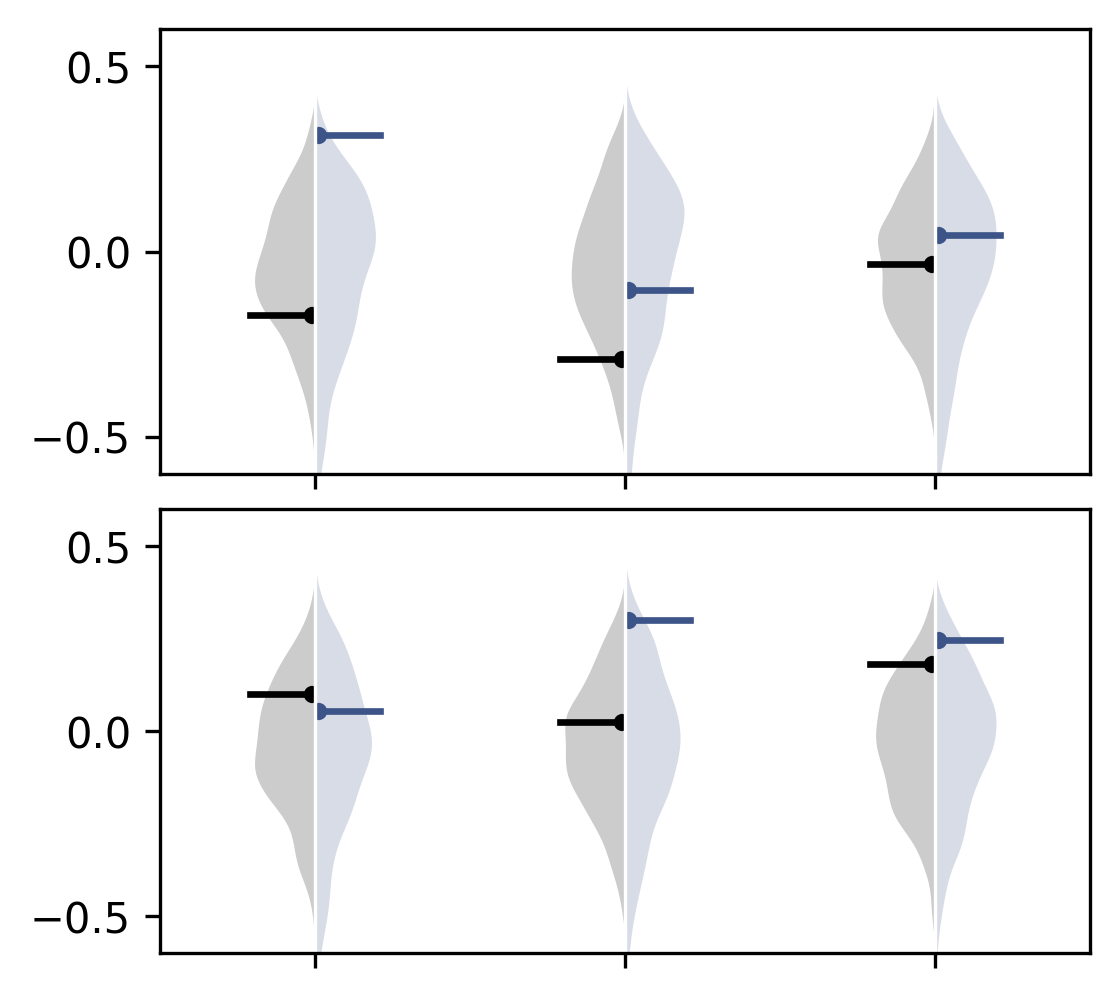

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.collections import PolyCollection
from matplotlib.markers import MarkerStyle


def patch_violinplot():
    for ax in axes:
        for art in ax.get_children():
            if isinstance(art, PolyCollection):
                art.set_edgecolor((1.0, 1.0, 1.0))


hc_model_connectivity = np.load('_DATA/hippocampo_cortical_model_predictivity.npy')[1]
hc_null_connectivity = np.load('_DATA/hippocampo_cortical_null_predictivity.npy')

cc_model_predictivity = np.load('_DATA/cortico_cortical_without_hippocampus_model_predictivity.npy')
cc_null_predictivity = np.load("_DATA/cortico_cortical_without_hippocampus_null_predictivity.npy")

# statistical significance
N_permutations = 1000
for b in range(2):
    for t in [2,1,0]:
        print(b, t, hc_model_connectivity[b,t],
              (1+np.sum(hc_null_connectivity[b,t,:]>=hc_model_connectivity[b,t]))/(1+N_permutations))

dfs = []
for b in range(2):
    df = pd.DataFrame(data={'null': np.hstack([cc_null_predictivity[b, 2, :],
                                               hc_null_connectivity[b, 2, :],
                                               cc_null_predictivity[b, 1, :],
                                               hc_null_connectivity[b, 1, :],
                                               cc_null_predictivity[b, 0, :],
                                               hc_null_connectivity[b, 0, :]]),
                            'moments': np.hstack([["Retrieval"] * 2000 + ['Post'] * 2000 + ['All'] * 2000]),
                            'type': np.hstack([["wholebrain"] * 1000 + ['hipp'] * 1000] * 3)})
    dfs.append(df)

displayed_timepoints = np.array([2, 1, 0])

import seaborn as sns

plt.style.use('default')
color_palette = sns.color_palette("crest", 10)

fig, axes = plt.subplots(2, 1, figsize=(4, 4), dpi=300, sharex=True, sharey=True)
width = 0.22
offset = 0.008
offset2 = 0.01
x = np.arange(len(displayed_timepoints))

color_list = [[0.0, 0.0, 0.0, 0.2], [60 / 255, 84 / 255, 136 / 255, 0.2]] * 3

for b in range(2):

    sns.violinplot(data=dfs[b], x='moments', y='null',
                   split=True, hue='type',
                   ax=axes[b], width=0.4, inner=None, color="#777777",
                   linewidth=0.6, zorder=1)
    for i, v in enumerate(axes[b].findobj(PolyCollection)):
        v.set_facecolor(color_list[i])
    axes[b].scatter([0 + offset, 1 + offset, 2 + offset],
                    [hc_model_connectivity[b, 2],
                     hc_model_connectivity[b, 1],
                     hc_model_connectivity[b, 0]], s=10, c='#3C5488', marker=MarkerStyle("o", fillstyle="right"))
    axes[b].plot([0 + offset, 0.2 + offset], [hc_model_connectivity[b, 2], hc_model_connectivity[b, 2]], c='#3C5488',
                 lw=1.6)
    axes[b].plot([1 + offset, 1.2 + offset], [hc_model_connectivity[b, 1], hc_model_connectivity[b, 1]], c='#3C5488',
                 lw=1.6)
    axes[b].plot([2 + offset, 2.2 + offset], [hc_model_connectivity[b, 0], hc_model_connectivity[b, 0]], c='#3C5488',
                 lw=1.6)
    axes[b].scatter([0 - offset2, 1 - offset2, 2 - offset2],
                    [cc_model_predictivity[b, 2],
                     cc_model_predictivity[b, 1],
                     cc_model_predictivity[b, 0]], s=10, c='#000000', marker=MarkerStyle("o", fillstyle="left"))
    axes[b].plot([-0.2 - offset2, 0.0 - offset2],
                 [cc_model_predictivity[b, 2], cc_model_predictivity[b, 2]], c='#000000', lw=1.6)
    axes[b].plot([0.8 - offset2, 1.0 - offset2],
                 [cc_model_predictivity[b, 1], cc_model_predictivity[b, 1]], c='#000000', lw=1.6)
    axes[b].plot([1.8 - offset2, 2.0 - offset2],
                 [cc_model_predictivity[b, 0], cc_model_predictivity[b, 0]], c='#000000', lw=1.6)

patch_violinplot()
for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    ax.set_ylim(-0.6, 0.6)
    ax.legend().set_visible(False)
    ax.set_yticks([-0.5, 0.0, 0.5])
    ax.axvline(0.0, c='w', lw=0.8)
    ax.axvline(1.0, c='w', lw=0.8)
    ax.axvline(2.0, c='w', lw=0.8)
plt.xlim(-0.5, 2.5)
plt.subplots_adjust(hspace=0.08)
plt.show()

Ordering score vs. hippocampus-vmPFC at sequencing moments
PearsonRResult(statistic=-0.36974595261247883, pvalue=0.00243456336655859)


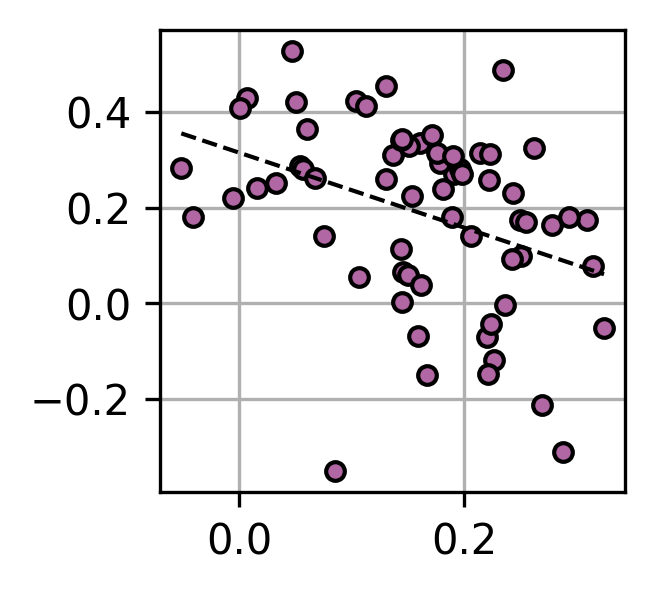

In [14]:
plt.style.use('default')
print('Ordering score vs. hippocampus-vmPFC at sequencing moments')

atlas_idx = 1
num_rois = (atlas_idx+1)*100

roi = 191 -1 # vmPFC
plt.figure(figsize=(2,2), dpi=300)
y = np.arctanh(hippocampo_cortical_FC[atlas_idx][:,roi, 2])
x = ordering_score
plt.scatter(x, y, s=20, c='#B067A4', edgecolors='k', zorder=100)

slope, intercept, r, p, stderr = linregress(x, y)
x_range = np.array([np.min(x), np.max(x)])
plt.plot(x_range, intercept + slope * x_range, 'k--', label='r={:0.3f}, p={:0.3f}'.format(r, p),
         zorder=100, lw=1)

plt.grid(True, zorder=0)
print(pearsonr(x, y))

Content score vs. hippocampus-PMC at post-event boundaries
PearsonRResult(statistic=0.2589190458297614, pvalue=0.037285204278565)


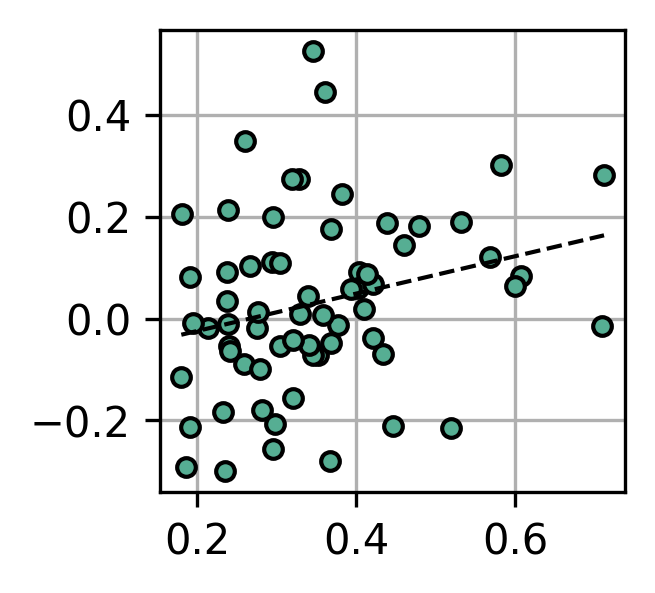

In [17]:
print('Content score vs. hippocampus-PMC at post-event boundaries')
atlas_idx = 1
num_rois = (atlas_idx+1)*100

roi = 199-1 # PMC
plt.figure(figsize=(2,2), dpi=300)
y = np.arctanh(hippocampo_cortical_FC[atlas_idx][:,roi, 1])
x = content_score
plt.scatter(x, y, s=20, c='#56AE93', edgecolors='k', zorder=100)

slope, intercept, r, p, stderr = linregress(x, y)
x_range = np.array([np.min(x), np.max(x)])
plt.plot(x_range, intercept + slope * x_range, 'k--', label='r={:0.3f}, p={:0.3f}'.format(r, p),
         zorder=100, lw=1)

plt.grid(True, zorder=0)
print(pearsonr(x, y))

Ordering score vs. hippocampus-PMC at post-event bounddaries
PearsonRResult(statistic=0.029942454137640087, pvalue=0.8128330340778291)


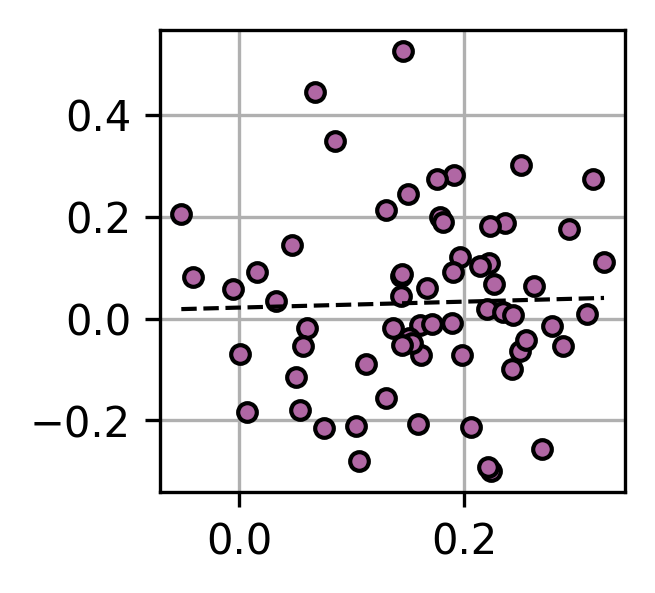

In [18]:
print('Ordering score vs. hippocampus-PMC at post-event boundaries')
atlas_idx = 1
num_rois = (atlas_idx+1)*100

roi = 199-1 # PMC
plt.figure(figsize=(2,2), dpi=300)
y = np.arctanh(hippocampo_cortical_FC[atlas_idx][:, roi, 1])
x = ordering_score
plt.scatter(x, y, s=20, c='#B067A4', edgecolors='k', zorder=100)

slope, intercept, r, p, stderr = linregress(x, y)
x_range = np.array([np.min(x), np.max(x)])
plt.plot(x_range, intercept + slope * x_range, 'k--', label='r={:0.3f}, p={:0.3f}'.format(r, p),
         zorder=100, lw=1)

plt.grid(True, zorder=0)
print(pearsonr(x, y))

Content score vs. hippocampus-vmPFC at sequencing moments
PearsonRResult(statistic=0.03692395543731666, pvalue=0.770276017641379)


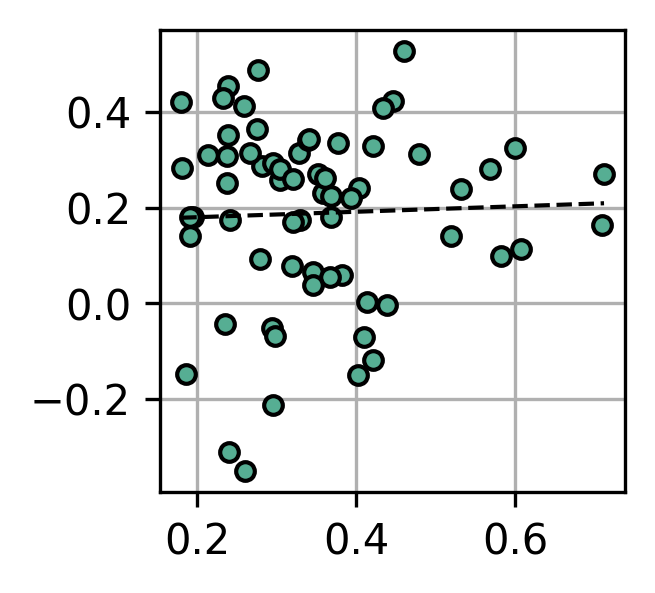

In [19]:
print('Content score vs. hippocampus-vmPFC at sequencing moments')
atlas_idx = 1
num_rois = (atlas_idx+1)*100

roi = 191-1 # vmPFC
plt.style.use('default')
plt.figure(figsize=(2,2), dpi=300)
y = hippocampo_cortical_FC[atlas_idx][:,roi, 2]
y = np.arctanh(y)
x = content_score
plt.scatter(x, y, s=20, c='#56AE93', edgecolors='k', zorder=100)
slope, intercept, r, p, stderr = linregress(x, y)
x_range = np.array([np.min(x), np.max(x)])
plt.plot(x_range, intercept + slope * x_range, 'k--', label='r={:0.3f}, p={:0.3f}'.format(r, p),
         zorder=100, lw=1)
plt.grid(True, zorder=0)

print(pearsonr(x, y))

Started server on port 32063
{'camera.azimuth': 0, 'camera.altitude': 90, 'camera.target': [0, 0, 0], 'surface.{subject}.unfold': 1.0, 'surface.{subject}.pivot': 180, 'surface.{subject}.shift': 10, 'surface.{subject}.specularity': 0, 'surface.{subject}.sampler': 'nearest', 'surface.{subject}.layers': 1}
{'camera.azimuth': 180, 'camera.altitude': 90, 'camera.target': [0, 0, 0], 'surface.{subject}.unfold': 1.0, 'surface.{subject}.pivot': 180, 'surface.{subject}.shift': 10, 'surface.{subject}.specularity': 0, 'surface.{subject}.sampler': 'nearest', 'surface.{subject}.layers': 1}
Stopping server
Stopping server


/tmp/ipykernel_1681868/3574026150.py:70: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


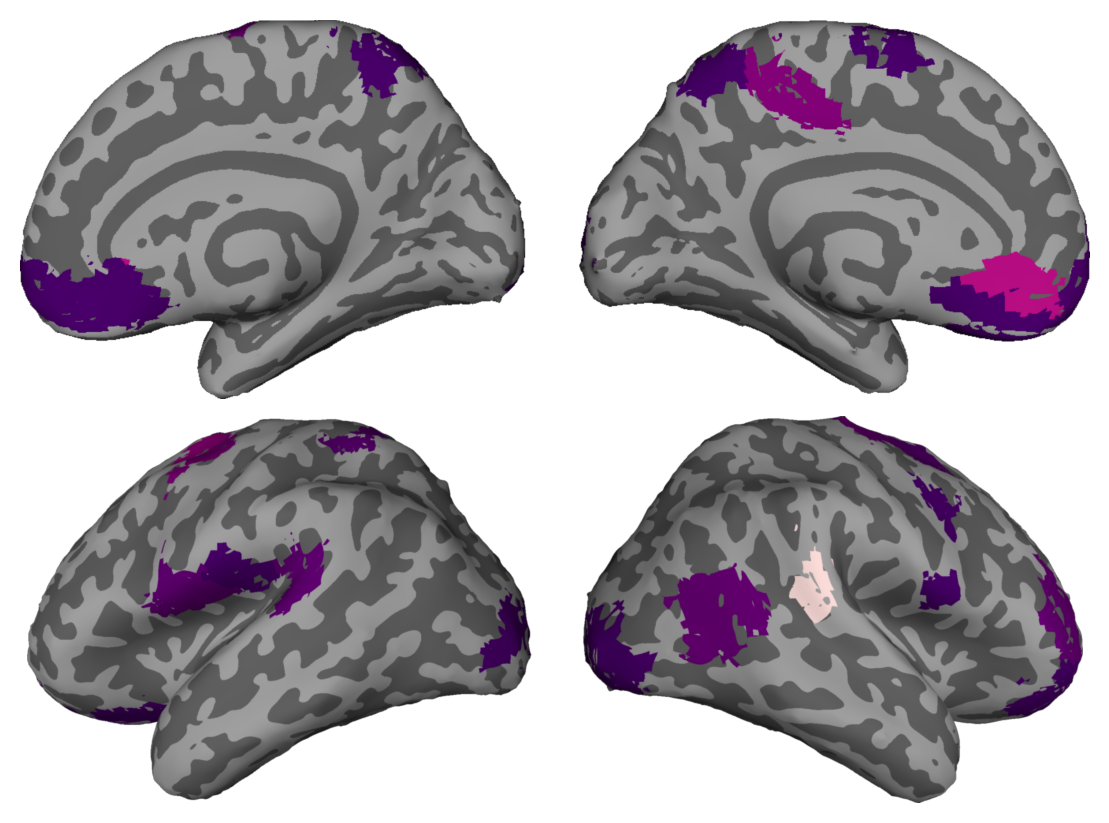

In [20]:
# IMPORTANT NOTE: Running this cell will restart the jupyter kernel,
#                 due to the use of the figure export in pycortex package
#                 Please run this cell in a separate jupyter notebook

import os
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cortex
base_name = os.path.join(tempfile.mkdtemp(), 'fig')

num_rois = 200
Schaefer_atlas = nib.load(f"utils/brain_atlas/Schaefer2018_cortical_{num_rois}_3mm.nii.gz").get_fdata()
model_positive_edges = np.load(f'_DATA/selected_edges/model_positive_edges_{num_rois}.npy')
model_negative_edges = np.load(f'_DATA/selected_edges/model_negative_edges_{num_rois}.npy')
hippocampus_idx = [215, 216, 217, 218]
r_statmap = np.zeros(Schaefer_atlas.shape)

b = 0 # 0 for ordering score, 1 for content score
t = 2 # 0: all timepoints, 1: post-event boundaries, 2: sequencing moments
for r in range(num_rois):
    r_1 = np.sum([model_positive_edges[b,t,r], model_negative_edges[b,t,r]])
    if r_1>0.1:
        r_statmap[Schaefer_atlas==r+1] = r_1
r_statmap[r_statmap<0.1] = np.nan

cmax = 1.0
cmin = 0.0

cmap = 'RdPu'
cmap_label = 'Edge selection'
vol_data = cortex.Volume(r_statmap.transpose(2,1,0), 'MNI152', 'fmriprep',
                         cmap=cmap, colorbar=True, vmax=cmax, vmin=cmin)

filenames = cortex.export.save_3d_views(
                vol_data, base_name=base_name,
                list_angles=['medial_pivot', 'lateral_pivot'], #medial_pivot or lateral_pivot
                list_surfaces=['inflated', 'inflated'],
                size=(1024 * 4, 768 * 2), trim=True,)

fig = plt.figure(constrained_layout=True, dpi=200, figsize=(6,4))
gs = fig.add_gridspec(2, 1, height_ratios=[4.95, 5.05])

ax1 = fig.add_subplot(gs[0])
ax1.imshow(plt.imread(filenames[0]), interpolation='gaussian')
ax1.axis('off')

#create custom cmap
draw_cax = False
if draw_cax:
    cax = fig.add_axes([0.437, 0.515, 0.15, 0.03])
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    cax.imshow(gradient, aspect='auto', cmap=cmap)
    pos = list(cax.get_position().bounds)
    x_text_left = pos[0] - 0.01
    x_text_center = pos[0] + pos[2]/2.
    x_text_right = pos[0] + pos[2] + 0.01
    y_text = pos[1] + pos[3]/2.
    y_text_bottom = pos[1] - 0.01
    fig.text(x_text_left, y_text, '{:0.2f}'.format(cmin), va='center', ha='right', fontsize=7)
    fig.text(x_text_right, y_text, '{:0.2f}'.format(cmax), va='center', ha='left', fontsize=7)
    fig.text(x_text_center, y_text_bottom, cmap_label, va='top', ha='center', fontsize=7)
    cax.axis('off')

ax2 = fig.add_subplot(gs[1])
ax2.imshow(plt.imread(filenames[1]), interpolation='gaussian')
ax2.axis('off')
plt.subplots_adjust(hspace=0.01)

Started server on port 22369
{'camera.azimuth': 0, 'camera.altitude': 90, 'camera.target': [0, 0, 0], 'surface.{subject}.unfold': 1.0, 'surface.{subject}.pivot': 180, 'surface.{subject}.shift': 10, 'surface.{subject}.specularity': 0, 'surface.{subject}.sampler': 'nearest', 'surface.{subject}.layers': 1}
{'camera.azimuth': 180, 'camera.altitude': 90, 'camera.target': [0, 0, 0], 'surface.{subject}.unfold': 1.0, 'surface.{subject}.pivot': 180, 'surface.{subject}.shift': 10, 'surface.{subject}.specularity': 0, 'surface.{subject}.sampler': 'nearest', 'surface.{subject}.layers': 1}
Stopping server
Stopping server


/tmp/ipykernel_1683953/2116056313.py:70: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


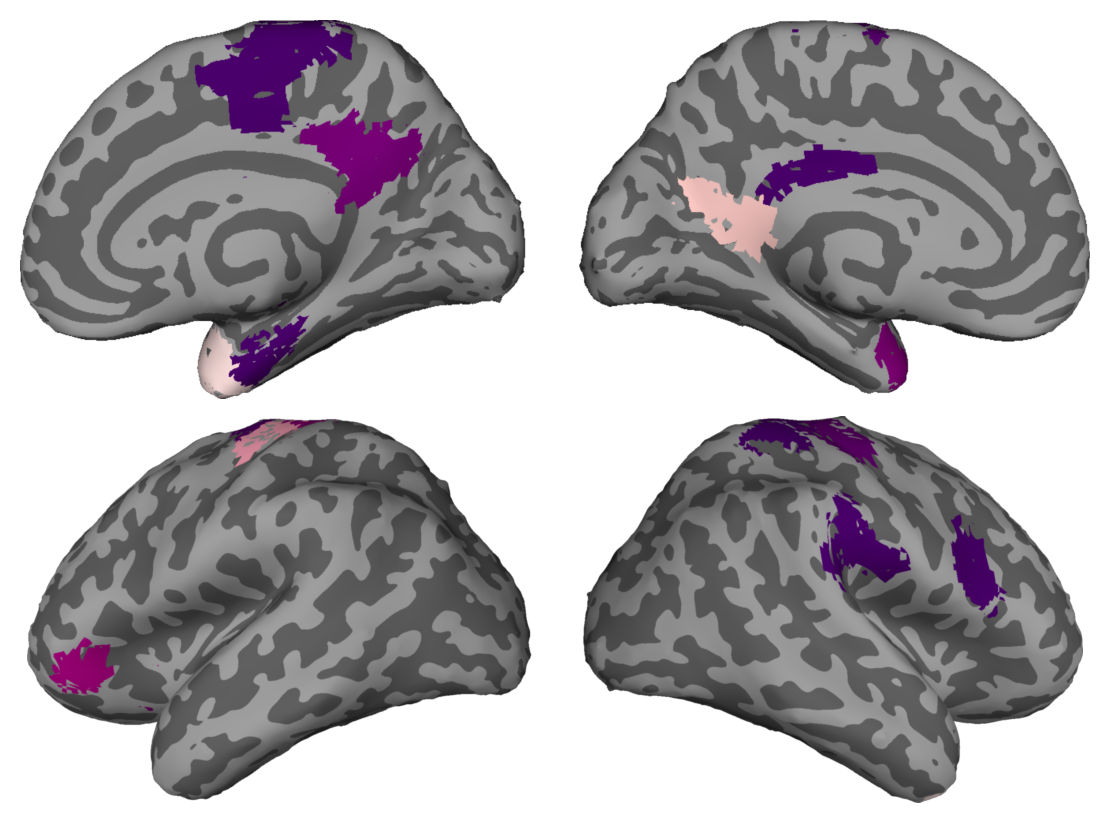

In [1]:
# IMPORTANT NOTE: Running this cell will restart the jupyter kernel,
#                 due to the use of the figure export in pycortex package
#                 Please run this cell in a separate jupyter notebook

import os
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cortex
base_name = os.path.join(tempfile.mkdtemp(), 'fig')

num_rois = 200
Schaefer_atlas = nib.load(f"utils/brain_atlas/Schaefer2018_cortical_{num_rois}_3mm.nii.gz").get_fdata()
model_positive_edges = np.load(f'_DATA/selected_edges/model_positive_edges_{num_rois}.npy')
model_negative_edges = np.load(f'_DATA/selected_edges/model_negative_edges_{num_rois}.npy')
hippocampus_idx = [215, 216, 217, 218]
r_statmap = np.zeros(Schaefer_atlas.shape)

b = 1 # 0 for ordering score, 1 for content score
t = 1 # 0: all timepoints, 1: post-event boundaries, 2: sequencing moments
for r in range(num_rois):
    r_1 = np.sum([model_positive_edges[b,t,r], model_negative_edges[b,t,r]])
    if r_1>0.1:
        r_statmap[Schaefer_atlas==r+1] = r_1
r_statmap[r_statmap<0.1] = np.nan

cmax = 1.0
cmin = 0.0

cmap = 'RdPu'
cmap_label = 'Edge selection'
vol_data = cortex.Volume(r_statmap.transpose(2,1,0), 'MNI152', 'fmriprep',
                         cmap=cmap, colorbar=True, vmax=cmax, vmin=cmin)

filenames = cortex.export.save_3d_views(
                vol_data, base_name=base_name,
                list_angles=['medial_pivot', 'lateral_pivot'], #medial_pivot or lateral_pivot
                list_surfaces=['inflated', 'inflated'],
                size=(1024 * 4, 768 * 2), trim=True,)

fig = plt.figure(constrained_layout=True, dpi=200, figsize=(6,4))
gs = fig.add_gridspec(2, 1, height_ratios=[4.95, 5.05])

ax1 = fig.add_subplot(gs[0])
ax1.imshow(plt.imread(filenames[0]), interpolation='gaussian')
ax1.axis('off')

#create custom cmap
draw_cax = False
if draw_cax:
    cax = fig.add_axes([0.437, 0.515, 0.15, 0.03])
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    cax.imshow(gradient, aspect='auto', cmap=cmap)
    pos = list(cax.get_position().bounds)
    x_text_left = pos[0] - 0.01
    x_text_center = pos[0] + pos[2]/2.
    x_text_right = pos[0] + pos[2] + 0.01
    y_text = pos[1] + pos[3]/2.
    y_text_bottom = pos[1] - 0.01
    fig.text(x_text_left, y_text, '{:0.2f}'.format(cmin), va='center', ha='right', fontsize=7)
    fig.text(x_text_right, y_text, '{:0.2f}'.format(cmax), va='center', ha='left', fontsize=7)
    fig.text(x_text_center, y_text_bottom, cmap_label, va='top', ha='center', fontsize=7)
    cax.axis('off')

ax2 = fig.add_subplot(gs[1])
ax2.imshow(plt.imread(filenames[1]), interpolation='gaussian')
ax2.axis('off')
plt.subplots_adjust(hspace=0.01)